# Classical BCI Pipeline

In this notebook, we will go through all the steps to make a simple BCI classification task, downloading a dataset and using a standard classifier. We choose the dataset 2a from BCI Competition IV, a motor imagery task. We will use a CSP to enhance the signal-to-noise ratio of the EEG epochs and a LDA to classify these signals.

First, we need to import all the methods for reading the data, filtering and pre-processing the EEG, classifying the signals and plotting the results.

In [1]:
from scipy.io import loadmat
import numpy as np
import mne
from mne import create_info
from mne.io import RawArray
from mne.channels import read_montage
import glob

from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
from mne.decoding import CSP
import pandas as pd

In [2]:
%matplotlib inline

## Picking up a dataset

We will work on the *BCI Competition IV Dataset 2a*. This dataset consists of EEG data from 9 subjects. The cue-based BCI paradigm consisted of four different motor imagery tasks, we will only focus on the left hand (class 1) and right hand (class 2). Two sessions on different days were recorded for each subject. Each session is comprised of 6 runs separated by short breaks. One run consists of 48 trials (12 for each of the four possible classes), yielding a total of 288 trials per session. Considering only left and right trials, we have 144 trials by session.

The cue is shown to the subjects two seconds ($t$ = 2s) after the start of the trial and the subjects were ask to carry out the motor imagery task until the fixation cross disappeared from the screen at $t$ = 6s.

Twenty-two Ag/AgCl electrodes were used to record the EEG. All signals were recorded monopolarly with the left mastoid serving as reference and the right mastoid as ground. The signals were sampled at 250 Hz and bandpass-filtered between 0.5 Hz and 100 Hz. The sensitivity of the amplifier was set to 100 $\mu$V. An additional 50 Hz notch filter was enabled to suppress line noise

We will need to download the data either manually from the [BNCI website](http://bnci-horizon-2020.eu/database/data-sets) or with the following command that should work on Linux/Mac:

In [3]:
!mkdir -p dataset/001-2014
!for f in A01T A01E A02T A02E A03T A03E A04T A04E A05T A05E A06T A06E A07T A07E A08T A08E A09T A09E; do curl -C - -o dataset/001-2014/"$f".mat https://lampx.tugraz.at/~bci/database/001-2014/"$f".mat; done

** Resuming transfer from byte position 42806453
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   396    0   396    0     0   2010      0 --:--:-- --:--:-- --:--:--  2010
** Resuming transfer from byte position 43772146
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   396    0   396    0     0   2237      0 --:--:-- --:--:-- --:--:--  2224
** Resuming transfer from byte position 43068077
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   396    0   396    0     0   2237      0 --:--:-- --:--:-- --:--:--  2250
** Resuming transfer from byte position 44218409
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
             

## One session at a time

Let's focus on the first subject, picking one session with 6 runs of 48 trials, that is 144 trials for left and right hand imagery. We will exclude feet and tongue trials.

In [4]:
filename = "./dataset/001-2014/A01E.mat"

### Reading the data

We need to load the file `A01E.mat` that is store as MATLAB file with scipy loadmat function. From the .mat file, we need to get the actual EEG data that are stored as a list of runs.

In [5]:
runs = []
event_id = {}
data = loadmat(filename, struct_as_record=False, squeeze_me=True)
run_array = data['data']

For each run, we need to identify the correct electrodes names and position and there is 3 EOG channels. We use MNE to infer electrode position from their name (using 10-20 system). To benefit from MNE, we need to provide some information: channel names and types, sampling frequency and montage. We also need to keep track events id. 
For further processing, we need to supply the sampling frequency `sfreq` to MNE.

Instead of just 6 runs, there is 9 runs because there are 3 baseline runs that do not contains any trials, only resting state. We need to discard those runs.

In [6]:
for run in run_array:

    ch_names = [
        'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2',
        'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz',
        'EOG1', 'EOG2', 'EOG3'
    ]
    ch_types = ['eeg'] * 22 + ['eog'] * 3    
    
    evd = {}
    n_chan = run.X.shape[1]
    montage = read_montage('standard_1005')
    eeg_data = 1e-6 * run.X
    sfreq = run.fs

    trigger = np.zeros((len(eeg_data), 1))
    # some runs does not contains trials i.e baseline runs
    if len(run.trial) > 0:
        trigger[run.trial - 1, 0] = run.y

    eeg_data = np.c_[eeg_data, trigger]
    ch_names = ch_names + ['stim']
    ch_types = ch_types + ['stim']
    evd = {ev: (ii + 1) for ii, ev in enumerate(run.classes)}
    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
    rawi = RawArray(data=eeg_data.T, info=info, verbose=False)    
    
    runs.append(rawi)
    event_id.update(evd)

### Combine and filter 

We could now concatenate all trial runs to make a session. It is also a good time to filter the EEG between 8 and 32 Hz.

In [7]:
raw = mne.concatenate_raws(runs)
raw.filter(l_freq=8, h_freq=32, method='iir')

<RawArray  |  None, n_channels x n_times : 26 x 686200 (2744.8 sec), ~136.2 MB, data loaded>

We will extract the trials across all the runs; we pick the signal between $t+2$ to $t+6$s, gathering trials only from left and right hand class, excluding other classes. Relying on MNE, it is straightforward.

In [8]:
events = mne.find_events(raw)
epochs = mne.Epochs(raw, events, event_id={'left hand':1, 'right hand':2}, tmin=2, tmax=6, 
                    baseline=None, picks=mne.pick_types(raw.info, eeg=True, stim=False))

288 events found
Event IDs: [1 2 3 4]
144 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


### Preprocess

The EEG will now be processed by scikit-learn, we need to extract the data $X$ and the label $y$.

In [9]:
X = epochs.get_data()
y = epochs.events[:,-1]

Loading data for 144 events and 1001 original time points ...
0 bad epochs dropped


### Classification

Scikit pipeline object allows to automate preprocessing and classification task. It also eases the parameter search or optimization as we will see later.

Our pipeline is simple, we want to apply a [CSP](https://my.ece.utah.edu/~ece6534/notes/2017_ece6534_lecture28.pdf) to filter the data using the eigenvectors associated with the four largest and four smallest eigenvalues. The resulting signal will be send to a simple [Linear Disciminant Analysis](https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda).

Scikit-learn expects labels to be between 0 and `n_classes-1`. To avoid potential problems if the trials are not labeled accordingly, we use [LabelEncoder](https://scikit-learn.org/stable/modules/preprocessing_targets.html#preprocessing-targets) to ensure that all labels follows scikit-learn convention.

In [10]:
pipeline = make_pipeline(CSP(n_components=8), LDA())
le = LabelEncoder()
y = le.fit_transform(y)

With scikit-learn, all the evaluation process is simplified. Here, we want to make a [$k$-fold validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) with $k=5$. Using [AUC](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics), our evaluation score is the mean AUC on the $k$-fold.

In [11]:
cv = StratifiedKFold(5, shuffle=False)
acc = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
print('AUC score is {:.1f}'.format(acc.mean() * 100))

Computing data rank from raw with rank=None
    Using tolerance 2.4e-05 (2.2e-16 eps * 22 dim * 4.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank=None
    Using tolerance 2.3e-05 (2.2e-16 eps * 22 dim * 4.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank=None
    Using tolerance 2.4e-05 (2.2e-16 eps * 22 dim * 4.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank=None
    Using tolerance 2.3e-05 (2.2e-16 eps * 22 dim * 4.8e+09  max 

We obtain an AUC score of 94.6 which is similar to common results obtained for subject 1 of this dataset.

## Extending to all subjects

To process the the data from all the subjects, we will gather all the code from above and put it in a function `get_session_score`. Given a filename and scikit pipeline, this function returns the mean AUC.

To keep the notebook clean, we discarded all the printed logs (warnings and information) but this is because we have already tested the code. 

In [12]:
import warnings
warnings.filterwarnings("ignore")
mne.set_log_level("CRITICAL")

def get_session_score(filename, pipeline):
    
    runs = []
    event_id = {}
    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
    run_array = data['data']
    for run in run_array:

        ch_names = [
            'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2',
            'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz',
            'EOG1', 'EOG2', 'EOG3'
        ]
        ch_types = ['eeg'] * 22 + ['eog'] * 3    

        evd = {}
        n_chan = run.X.shape[1]
        montage = read_montage('standard_1005')
        eeg_data = 1e-6 * run.X
        sfreq = run.fs

        if not ch_names:
            ch_names = ['EEG%d' % ch for ch in range(1, n_chan + 1)]
            montage = None  # no montage

        if not ch_types:
            ch_types = ['eeg'] * n_chan

        trigger = np.zeros((len(eeg_data), 1))
        # some runs does not contains trials i.e baseline runs
        if len(run.trial) > 0:
            trigger[run.trial - 1, 0] = run.y

        eeg_data = np.c_[eeg_data, trigger]
        ch_names = ch_names + ['stim']
        ch_types = ch_types + ['stim']
        evd = {ev: (ii + 1) for ii, ev in enumerate(run.classes)}
        info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
        rawi = RawArray(data=eeg_data.T, info=info, verbose=False)    

        runs.append(rawi)
        event_id.update(evd)    
        
    raw = mne.concatenate_raws(runs)
    raw.filter(l_freq=8, h_freq=32, method='iir')   
    
    events = mne.find_events(raw)
    epochs = mne.Epochs(raw, events, event_id={'left hand':1, 'right hand':2}, tmin=2, tmax=6, baseline=None, picks=mne.pick_types(raw.info, eeg=True, stim=False))
    X = epochs.get_data()
    y = epochs.events[:,-1]    
    
    cv = StratifiedKFold(5, shuffle=False)
    le = LabelEncoder()
    y = le.fit_transform(y)
    acc = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
    
    return acc.mean()

To verify that the function works as expected, we apply it on our data from first subject `A01E.mat`.

In [13]:
pipeline = make_pipeline(CSP(n_components=8), LDA())
score = get_session_score(filename, pipeline)
print("{:.1f}".format(score * 100))

94.6


The score is the same, we could move to processing all session files from all 9 subjects. 

### Evaluation

To ease the plot of the results we will use [seaborn](https://seaborn.pydata.org/) and we need to format the data in a [panda's DataFrame](https://pandas.pydata.org/pandas-docs/stable/getting_started/dsintro.html). For this notebook, we could see DataFrame as powerful dictionary-like structure. 

For all files from the dataset, we get the AUC score and we log the session and subject to put everything in a DataFrame.

In [14]:
scores = []
subjects = []
sessions = []
pipeline = make_pipeline(CSP(n_components=8), LDA())

for filename in glob.glob('./dataset/001-2014/*'):
    print(filename)

    score = get_session_score(filename, pipeline)    
    scores.append(score)
    
    session_name = 'session_' + filename.split('.')[1][-1]
    sessions.append(session_name)
    
    subject = int(filename.split('.')[1][-2])    
    subjects.append(subject)
    
results = pd.DataFrame()
results['score'] = scores
results['subject'] = subjects
results['session'] = sessions

./dataset/001-2014/A05E.mat
./dataset/001-2014/A08T.mat
./dataset/001-2014/A09E.mat
./dataset/001-2014/A04T.mat
./dataset/001-2014/A05T.mat
./dataset/001-2014/A08E.mat
./dataset/001-2014/A09T.mat
./dataset/001-2014/A04E.mat
./dataset/001-2014/A02T.mat
./dataset/001-2014/A03E.mat
./dataset/001-2014/A02E.mat
./dataset/001-2014/A03T.mat
./dataset/001-2014/A01E.mat
./dataset/001-2014/A01T.mat
./dataset/001-2014/A07E.mat
./dataset/001-2014/A06T.mat
./dataset/001-2014/A07T.mat
./dataset/001-2014/A06E.mat


### Plot the results

We could plot the results with seaborn. For each session of each subject, we have a average AUC score.

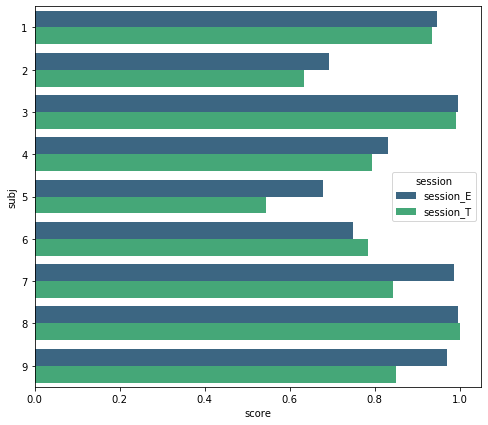

In [18]:
fig, ax = plt.subplots(figsize=(8,7))
results["subj"] = results["subject"].apply(str)
sns.barplot(x="score", y="subj", hue='session', data=results, orient='h', palette='viridis', ax=ax)
# sns.catplot(kind='bar', x="score", y="subj", hue='session', data=results, orient='h', palette='viridis')
fig.show()